# Time series

**Prerequisites**

- Python functions
- GroupBy


**Outcomes**

- Know how pandas handles dates  
- Understand how to parse strings into `datetime` objects  
- Know how to write dates as custom formatted strings  
- Be able to access day, month, year, etc. for a `DateTimeIndex` and
  a column with `dtype` `datetime`  
- Understand both rolling and re-sampling operations and the difference
  between the two  


**Data**

- Bitcoin to USD exchange rates from March 2014 to the present  

## Outline

- [Time series](#Time-series)  
  - [Intro](#Intro)  
  - [Parsing Strings as Dates](#Parsing-Strings-as-Dates)  
  - [Date Formatting](#Date-Formatting)  
  - [Extracting Data](#Extracting-Data)  
  - [Accessing Date Properties](#Accessing-Date-Properties)  
  - [Leads and Lags: `df.shift`](#Leads-and-Lags:-`df.shift`)  
  - [Rolling Computations: `.rolling`](#Rolling-Computations:-`.rolling`)  
  - [Changing Frequencies: `.resample`](#Changing-Frequencies:-`.resample`)  
  - [Optional: API keys](#Optional:-API-keys)  
  - [Exercises](#Exercises)  

In [41]:
# Uncomment following line to install on colab
%pip install quandl

You should consider upgrading via the '/Users/fabrizio/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [42]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import quandl

# see section on API keys at end of lecture!
quandl.ApiConfig.api_key = os.environ.get("QUANDL_AUTH", "Dn6BtVoBhzuKTuyo6hbp")
start_date = "2014-05-01"

%matplotlib inline
# activate plot theme
plt.style.use("ggplot")

## Intro

pandas has extensive support for handling dates and times

We will loosely refer to data with date or time information as time
series data

Today we'll explore pandas timeseries capabilities

Among these topics are:

- Parsing strings as dates  
- Writing `datetime` objects as (inverse operation of previous point)  
- Extracting data from a DataFrame or Series with date information in
  the index  
- Shifting data through time (taking leads or lags)  
- Re-sampling data to a different frequency and rolling operations  

**NOTE:** here, even more than with previous topics, we will skip a lot of the
functionality pandas offers, and we urge you to refer to the [official
documentation](https://pandas.pydata.org/pandas-docs/stable/timeseries.html)
for more information

## Parsing Strings as Dates

Dates often come to us as strings

Hopefully, the date strings follow a structured format or pattern

One common pattern is `YYYY-MM-DD`: 4 numbers for the year, 2 for the
month, and 2 for the day with each section separated by a `-`

For example, we write Christmas day 2017 in this format as

In [43]:
christmas_str = "2020-12-25"

To convert a string into a time-aware object, we use the
`pd.to_datetime` function.

In [44]:
christmas = pd.to_datetime(christmas_str)
print("The type of christmas is", type(christmas))
christmas

The type of christmas is <class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2020-12-25 00:00:00')

The `pd.to_datetime` function is pretty smart at guessing the format
of the date…

In [45]:
# this means to parse striings as dates

for date in ["December 25, 2020", "Dec. 25, 2020",
             "Monday, Dec. 25, 2020", "25 Dec. 2020", "25th Dec. 2020"]:
    print("pandas interprets {} as {}".format(date, pd.to_datetime(date)))

pandas interprets December 25, 2020 as 2020-12-25 00:00:00
pandas interprets Dec. 25, 2020 as 2020-12-25 00:00:00
pandas interprets Monday, Dec. 25, 2020 as 2020-12-25 00:00:00
pandas interprets 25 Dec. 2020 as 2020-12-25 00:00:00
pandas interprets 25th Dec. 2020 as 2020-12-25 00:00:00


However, sometimes we will need to give pandas a hint

For example, that same time (midnight on Christmas) would be reported on
an Amazon transaction report as

In [46]:
christmas_amzn = "2020-12-25T00:00:00+ 00 :00"

If we try to pass this to `pd.to_datetime`, it will fail

In [47]:
# we knew that it was going to fail
'''
pd.to_datetime(christmas_amzn)
'''

'\npd.to_datetime(christmas_amzn)\n'

To parse a date with this format, we need to specify the `format`
argument for `pd.to_datetime`

In [48]:
# now we pass the same argument as before, but we add the method format
# amzn_strftime --> relates veery closely to christmas_amzn
# see next

amzn_strftime = "%Y-%m-%dT%H:%M:%S+ 00 :00"
pd.to_datetime(christmas_amzn, format=amzn_strftime)

Timestamp('2020-12-25 00:00:00')

Can you guess what `amzn_strftime` represents?

Let’s take a closer look at `amzn_strftime` and `christmas_amzn`

In [49]:
print(amzn_strftime)
print(christmas_amzn)

#oveerall format structure is very similar
# %Y--> 4 digits
# %m--> 2 digits
# %dT%H:%M:%S+ --> 25T00:00:00+

%Y-%m-%dT%H:%M:%S+ 00 :00
2020-12-25T00:00:00+ 00 :00


Notice that both of the strings have a similar form, but that instead of actual numerical values, `amzn_strftime` has *placeholders*

Specifically, anywhere the `%` shows up is a signal to the `pd.to_datetime`
function that it is where relevant information is stored

For example, the `%Y` is a stand-in for a four digit year, `%m` is
for 2 a digit month, and so on…

The official [Python
documentation](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) contains a complete list of possible `%`something patterns that are accepted
in the `format` argument

<a id='exercise-0'></a>
**Exercise 1**

By referring to table found at the link above, figure out the correct argument to
pass as `format` in order to parse the dates in the next three cells below.

Test your work by passing your format string to `pd.to_datetime`.

In [50]:
christmas_str2 = "2020:12:25"
christmas_str2_strftime = "%Y:%m:%d"
pd.to_datetime(christmas_str2,  format=christmas_str2_strftime)


Timestamp('2020-12-25 00:00:00')

In [51]:
dbacks_win = "M:11 D:4 Y:2001 9:15 PM"
dbacks_win_strftime = "%m-%d-%Y-%H:%M-%p"  
pd.to_datetime(dbacks_win,  format=dbacks_win_strftime, errors='ignore')


'M:11 D:4 Y:2001 9:15 PM'

In [52]:
america_bday = "July 4, 1776"
america_bday_strftime = "%B %d, %Y"
print("America was born on " + pd.to_datetime(america_bday,  format="%B-%d-%Y", errors='ignore'))

America was born on July 4, 1776


### Multiple Dates

`pd.to_datetime` can convert a collection (e.g. list, tuple, Series) of date strings to dates in one go


In [53]:
pd.to_datetime(["2020-12-25", "2020-12-31"])

DatetimeIndex(['2020-12-25', '2020-12-31'], dtype='datetime64[ns]', freq=None)

In [54]:
### pd.date_range

# pd.date_range(START, END, freq="") 


In [55]:
pd.date_range("2020-12-25", "2024-12-31", freq="A") 

# START, END, A=YEAR

DatetimeIndex(['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31',
               '2024-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

In [56]:
pd.date_range("2020-12-25", "2021-12-31")

# default daily

DatetimeIndex(['2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31', '2021-01-01',
               '2021-01-02', '2021-01-03',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=372, freq='D')

In [57]:
pd.date_range("2020-04-01", periods=25, freq="H")

# hourly frequency


DatetimeIndex(['2020-04-01 00:00:00', '2020-04-01 01:00:00',
               '2020-04-01 02:00:00', '2020-04-01 03:00:00',
               '2020-04-01 04:00:00', '2020-04-01 05:00:00',
               '2020-04-01 06:00:00', '2020-04-01 07:00:00',
               '2020-04-01 08:00:00', '2020-04-01 09:00:00',
               '2020-04-01 10:00:00', '2020-04-01 11:00:00',
               '2020-04-01 12:00:00', '2020-04-01 13:00:00',
               '2020-04-01 14:00:00', '2020-04-01 15:00:00',
               '2020-04-01 16:00:00', '2020-04-01 17:00:00',
               '2020-04-01 18:00:00', '2020-04-01 19:00:00',
               '2020-04-01 20:00:00', '2020-04-01 21:00:00',
               '2020-04-01 22:00:00', '2020-04-01 23:00:00',
               '2020-04-02 00:00:00'],
              dtype='datetime64[ns]', freq='H')

In [58]:
pd.date_range("2020-04-01", periods=25, freq="m")


DatetimeIndex(['2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30',
               '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31',
               '2022-04-30'],
              dtype='datetime64[ns]', freq='M')

In [59]:
### OFFSET ALIASES 

In [60]:
### TIME DELTA

In [61]:
new_year = pd.to_datetime("2020-01-01")
diff = christmas - new_year
print("diff is type", type(diff))
diff

diff is type <class 'pandas._libs.tslibs.timedeltas.Timedelta'>


Timedelta('359 days 00:00:00')

In [62]:
diff.seconds

0

In [63]:
diff.days

359

In [64]:
diff.days*10

3590

In [65]:
# if a time delta object is added 

In [66]:
oneday = pd.Timedelta(days=1)
onehour = pd.Timedelta(hours=1)
oneday + onehour

Timedelta('1 days 01:00:00')

In [67]:
christmas + 365*oneday

Timestamp('2021-12-25 00:00:00')

We'll just do the one example b/c everything for one date applies to a collection of dates 

## Date Formatting

We can use the `%`pattern format to have pandas write `datetime`
objects as specially formatted strings using the `strftime` (string
format time) method

For example,

In [68]:
christmas.strftime("We love %A %B %d (also written %c)")

# there is a documentation with all the codes

'We love Friday December 25 (also written Fri Dec 25 00:00:00 2020)'


<a id='exercise-1'></a>
**Exercise 2**

Use `pd.to_datetime` to express the birthday of one of your friends
or family members as a `datetime` object.

Then use the `strftime` method to write a message of the format:

In [112]:
# NAME's birthday is June 10, 1989 (a Saturday)\
birthday = "12 13 1997"
birthday_strftime = "%m %d %Y"
# pd.to_datetime(birthday,  format=birthday_strftime)
print("Fabrizio's birthday is " + pd.to_datetime(birthday, format=birthday_strftime, errors='ignore'))
# birthday.strftime("Fabrizio's birthday is %B %d %Y (a a% A%)")


TypeError: can only concatenate str (not "Timestamp") to str

(where the name and date are replaced by the appropriate values)

## Extracting Data

Pandas is aware of when DataFrames or Series have dates on the index

In these cases it uses a special `DateTimeIndex` for the index

The special index comes with many convenient data access features

We will explore these now

It's easiest to understand how they work by example, so we'll lload in some real world data:

In [70]:
btc_usd = quandl.get("BCHARTS/BITSTAMPUSD", start_date=start_date)
btc_usd.info()
btc_usd.head()

# we can see the DatetimeIndex and there are 2599 rows
# the dates START and END
# Open = first transaction price
# close = last transaction price
# high = highest transaction price

# we have all the dates on the index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2599 entries, 2014-05-01 to 2021-06-20
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               2599 non-null   float64
 1   High               2599 non-null   float64
 2   Low                2599 non-null   float64
 3   Close              2599 non-null   float64
 4   Volume (BTC)       2599 non-null   float64
 5   Volume (Currency)  2599 non-null   float64
 6   Weighted Price     2599 non-null   float64
dtypes: float64(7)
memory usage: 162.4 KB


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-02,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2014-05-03,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-04,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483
2014-05-05,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968


Here, we have the Bitcoin (BTC) to US dollar (USD) exchange rate from
March 2014 until today.

Notice that the type of index is `DateTimeIndex`.

This is the key that enables things like…

Extracting all data for the year 2015 by passing `"2015"` to `.loc`.

In [71]:
btc_usd.loc["2015"]

# if we want to extract information from 2015

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2015-01-01,321.00,321.00,312.60,313.81,3087.436554,9.745096e+05,315.637119
2015-01-02,313.82,317.01,311.96,315.42,3468.281375,1.092446e+06,314.981849
2015-01-03,315.42,316.58,280.00,282.00,21752.719146,6.475952e+06,297.707695
2015-01-04,280.00,289.39,255.00,264.00,41441.278553,1.126676e+07,271.872950
2015-01-05,264.55,280.00,264.07,276.80,9528.271002,2.596898e+06,272.546601
...,...,...,...,...,...,...,...
2015-12-27,417.11,425.42,410.50,421.76,6968.573659,2.921475e+06,419.235752
2015-12-28,421.78,429.86,417.01,421.46,7560.562992,3.204102e+06,423.791428
2015-12-29,420.81,433.33,418.55,431.82,10419.585366,4.444308e+06,426.534057


We can also narrow down to specific months.

In [72]:
# By month's name
btc_usd.loc["August 2017"]

# ["August 2017"] allows us to specify other keys and labels

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-08-01,2855.81,2929.17,2615.00,2731.00,12525.076691,3.432280e+07,2740.326259
2017-08-02,2732.00,2760.00,2650.00,2703.51,9486.625526,2.570111e+07,2709.193699
2017-08-03,2703.51,2807.44,2698.83,2793.37,7963.697999,2.193830e+07,2754.788542
2017-08-04,2793.34,2877.52,2765.91,2855.00,7635.821672,2.165009e+07,2835.331752
2017-08-05,2851.01,3339.66,2848.32,3263.62,16996.273101,5.386193e+07,3169.043337
2017-08-06,3263.51,3296.51,3146.10,3222.75,5998.735789,1.941266e+07,3236.124519
2017-08-07,3216.78,3430.00,3186.00,3387.55,12046.117265,4.022585e+07,3339.320971
2017-08-08,3387.54,3490.00,3300.00,3412.41,15835.370208,5.405482e+07,3413.549765
2017-08-09,3408.46,3423.10,3178.72,3342.99,14286.844138,4.735646e+07,3314.690350


In [73]:
# By month's number
btc_usd.loc["08/2017"]

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-08-01,2855.81,2929.17,2615.00,2731.00,12525.076691,3.432280e+07,2740.326259
2017-08-02,2732.00,2760.00,2650.00,2703.51,9486.625526,2.570111e+07,2709.193699
2017-08-03,2703.51,2807.44,2698.83,2793.37,7963.697999,2.193830e+07,2754.788542
2017-08-04,2793.34,2877.52,2765.91,2855.00,7635.821672,2.165009e+07,2835.331752
2017-08-05,2851.01,3339.66,2848.32,3263.62,16996.273101,5.386193e+07,3169.043337
2017-08-06,3263.51,3296.51,3146.10,3222.75,5998.735789,1.941266e+07,3236.124519
2017-08-07,3216.78,3430.00,3186.00,3387.55,12046.117265,4.022585e+07,3339.320971
2017-08-08,3387.54,3490.00,3300.00,3412.41,15835.370208,5.405482e+07,3413.549765
2017-08-09,3408.46,3423.10,3178.72,3342.99,14286.844138,4.735646e+07,3314.690350


In [74]:
btc_usd.loc["08/2017", ['High']]
# ["August 2017"] allows us to specify other keys and labels

,High
Date,
2017-08-01,2929.17
2017-08-02,2760.00
2017-08-03,2807.44
2017-08-04,2877.52
2017-08-05,3339.66
2017-08-06,3296.51
2017-08-07,3430.00
2017-08-08,3490.00
2017-08-09,3423.10


Or even a day…

In [75]:
# By date name
btc_usd.loc["August 1, 2020"]

Open                 1.135798e+04
High                 1.188336e+04
Low                  1.122800e+04
Close                1.181749e+04
Volume (BTC)         1.119581e+04
Volume (Currency)    1.302246e+08
Weighted Price       1.163155e+04
Name: 2020-08-01 00:00:00, dtype: float64

In [114]:
# By date number
btc_usd.loc["08-01-2020"]

Open                 1.135798e+04
High                 1.188336e+04
Low                  1.122800e+04
Close                1.181749e+04
Volume (BTC)         1.119581e+04
Volume (Currency)    1.302246e+08
Weighted Price       1.163155e+04
oc_diff              2.970200e+02
Name: 2020-08-01 00:00:00, dtype: float64

**Question:** What can we pass as the `.loc` argument when we have a
`DateTimeIndex`?

**Answer:** Anything that can be converted to a `datetime` using
`pd.to_datetime`, *without* having to specify the format argument.

When we pass date-like objects to `.loc`, pandas returns *all* rows whose date in the index "belong" to that date or period

We can also use the range shorthand notation to give a start and end
date for selection

In [77]:
btc_usd.loc["April 1, 2015":"April 10, 2015"]

# see that the end point is included

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2015-04-01,243.93,246.83,239.32,246.69,6226.016464,1.513601e+06,243.109050
2015-04-02,246.68,256.96,244.52,253.28,9806.822203,2.453664e+06,250.199655
2015-04-03,253.22,256.67,251.23,254.19,5048.577376,1.283171e+06,254.164902
2015-04-04,254.19,255.85,250.76,253.70,2769.281658,7.002845e+05,252.875870
2015-04-05,253.60,261.00,251.65,260.54,5759.360160,1.479483e+06,256.883285
2015-04-06,260.57,262.98,254.00,255.58,5960.677633,1.535495e+06,257.604180
2015-04-07,255.54,256.62,251.50,253.72,6010.267582,1.528034e+06,254.237260
2015-04-08,253.71,254.96,243.06,244.58,11663.656155,2.878712e+06,246.810407
2015-04-09,244.84,246.30,238.47,243.43,7943.710541,1.932558e+06,243.281478



<a id='exercise-2'></a>
**Exercise 3**

For each item in the list, extract the specified data from `btc_usd`:

- July 2017 through August 2017 (inclusive)  
- April 25, 2015 to June 10, 2016  
- October 31, 2017  

In [115]:
btc_usd.loc["July, 2017":"August, 2017"]


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,oc_diff
Date,,,,,,,,
2017-07-01,2465.48,2517.11,2390.00,2412.41,8885.893497,2.175049e+07,2447.755113,390.33
2017-07-02,2421.30,2528.72,2374.34,2504.37,8744.534411,2.138627e+07,2445.673226,309.70
2017-07-03,2504.81,2595.00,2472.68,2550.47,11520.707308,2.921371e+07,2535.756265,198.70
2017-07-04,2540.07,2639.47,2540.07,2596.12,9662.759414,2.510748e+07,2598.376075,253.30
2017-07-05,2594.52,2623.00,2530.10,2602.90,10882.839011,2.795034e+07,2568.295339,260.48
...,...,...,...,...,...,...,...,...
2017-08-27,4333.38,4393.30,4290.32,4337.68,3979.124453,1.726397e+07,4338.634650,-445.35
2017-08-28,4329.91,4399.72,4169.01,4379.99,8641.002446,3.707720e+07,4290.845145,-130.62
2017-08-29,4385.00,4649.78,4336.26,4578.82,11879.642831,5.349117e+07,4502.758977,-200.16


In [116]:
btc_usd.loc["April 25, 2015":"June 10, 2016"]


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,oc_diff
Date,,,,,,,,
2015-04-25,231.04,232.29,225.70,226.12,5286.098594,1.206595e+06,228.258103,4.55
2015-04-26,226.12,227.26,214.98,219.52,11238.356288,2.465554e+06,219.387440,9.59
2015-04-27,219.52,229.93,217.52,227.23,13816.491481,3.078036e+06,222.779892,15.65
2015-04-28,227.17,227.56,221.45,225.16,9345.783207,2.100834e+06,224.789478,9.29
2015-04-29,225.18,226.99,221.81,225.48,8668.360650,1.948799e+06,224.817524,10.85
...,...,...,...,...,...,...,...,...
2016-06-06,573.80,586.02,573.80,584.50,4465.516121,2.599633e+06,582.157234,100.90
2016-06-07,584.12,594.44,563.00,577.54,6705.918304,3.889184e+06,579.962868,54.07
2016-06-08,577.48,584.25,571.86,583.03,3259.151105,1.885761e+06,578.604855,85.52


## Accessing Date Properties


We can access parts of a date: e.g. the month, minute, second, or hour 

When the date/time information is in the index, we can to `df.index.XX`
where `XX` is replaced by `year`, `month`, or whatever we would
like to access.

In [117]:
btc_usd.loc["October 31, 2017"]


Open                 6.120000e+03
High                 6.449780e+03
Low                  6.072810e+03
Close                6.434210e+03
Volume (BTC)         1.342331e+04
Volume (Currency)    8.435448e+07
Weighted Price       6.284179e+03
oc_diff              3.827670e+03
Name: 2017-10-31 00:00:00, dtype: float64

In [78]:
btc_usd.index.year

Int64Index([2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='Date', length=2599)

In [79]:
btc_usd.index.day

# the days of the whole month plus some dayhs of the nexg month

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
           dtype='int64', name='Date', length=2599)

We can also do the same if the date/time information is stored in a
column, but we have to use a slightly different syntax.

```python
df["column_name"].dt.XX
```


Let's see it in action:

In [80]:
btc_date_column = btc_usd.reset_index()
btc_date_column.head()

# we put dates from index as columns

,Date,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,2014-05-01,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
1,2014-05-02,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2,2014-05-03,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
3,2014-05-04,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483
4,2014-05-05,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968


In [81]:
btc_date_column["Date"].dt.year.head()

# We can access parts of a date: year


0    2014
1    2014
2    2014
3    2014
4    2014
Name: Date, dtype: int64

In [82]:
btc_date_column["Date"].dt.month.head()

# We can access parts of a date: month


0    5
1    5
2    5
3    5
4    5
Name: Date, dtype: int64

## Leads and Lags: `df.shift`

When doing time series analysis, we often want to compare data at one
date against data at another date

pandas can help us with this if we leverage the `shift` method

Without any additional arguments, `shift()` will move all data
*forward* one period, filling the first row with missing data

In [83]:
# so we can see the result of shift clearly
# if the dates are on the index, this task is going to be difficult

btc_usd.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-02,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2014-05-03,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-04,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483
2014-05-05,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968


In [84]:
btc_usd.shift().head()

# .shift() --> on a datetime index
# it will move all data forward one period
# Here all the first for rows were moved down. We can see that because there is NaN

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-02,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-03,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2014-05-04,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-05,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483


We can use this to compute the percent change from one day to the next

(Quiz: Why does that work? Remember how pandas uses the index to *align*
data.)

In [85]:
((btc_usd - btc_usd.shift()) / btc_usd.shift()).head()

# We can use this to compute the percent change from one day to the next


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-02,0.026659,-0.006203,-0.007724,-0.014036,-0.134590,-0.148542,-0.016122
2014-05-03,-0.019459,-0.018337,-0.030393,-0.034103,-0.101363,-0.123282,-0.024391
2014-05-04,-0.028761,-0.025677,-0.003364,-0.002187,-0.306423,-0.313594,-0.010340
2014-05-05,-0.007107,0.004900,-0.010592,-0.011506,0.588559,0.580130,-0.005306


Setting the first argument to `n` tells pandas to shift the data down
`n` rows (apply an `n` period lag).

In [86]:
btc_usd.shift(3).head()

# SHIFTING BY THREE ROWS

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-04,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-05,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018


A negative value will shift the data *up* or apply a lead.

In [87]:
btc_usd.shift(-2).head()

# if we shit up and don't see any change then it is the caase that that i should look at the tail

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-02,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483
2014-05-03,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968
2014-05-04,431.64,434.00,420.27,428.01,8041.198415,3.439331e+06,427.713734
2014-05-05,429.00,452.00,425.67,440.00,13248.349023,5.842712e+06,441.014383


In [88]:
btc_usd.shift(-2).tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2021-06-16,38110.25,38208.68,35143.68,35840.00,4240.404867,1.560566e+08,36802.295855
2021-06-17,35849.18,36440.00,34718.21,35507.06,3129.334722,1.118542e+08,35743.751401
2021-06-18,35494.70,36125.00,33337.00,35675.47,3865.408811,1.344830e+08,34791.393581
2021-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<a id='exercise-3'></a>
**Exercise 4**

Using the `shift` function, determine the week with the largest percent change
in the volume of trades (the `"Volume (BTC)"` column).

Repeat the analysis at the bi-weekly and monthly frequencies.

Hint 1: We have data at a *daily* frequency and one week is `7` days.

Hint 2: Approximate a month by 30 days.

In [89]:
pct_change1 = btc_usd - btc_usd.shift(7) / btc_usd.shift(7)
pct_change1["Volume (BTC)"].describe()


count      2589.000000
mean       9957.221281
std        8141.754289
min          -1.000000
25%        4657.709626
50%        7657.871602
75%       12586.633922
max      105958.259141
Name: Volume (BTC), dtype: float64

In [90]:
import numpy as np
pct_change1["Volume (BTC)"].argmax()

552

In [91]:
btc_usd

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-02,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2014-05-03,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-04,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483
2014-05-05,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968
...,...,...,...,...,...,...,...
2021-06-16,40166.93,40506.59,38095.41,38353.99,4008.512964,1.574020e+08,39266.920444
2021-06-17,38361.38,39553.05,37350.00,38097.68,3569.252616,1.372355e+08,38449.364210
2021-06-18,38110.25,38208.68,35143.68,35840.00,4240.404867,1.560566e+08,36802.295855


In [137]:
week1 = 2599 / 7
week_sol1 = 552 / 7
print(week1)
print(week_sol1)

# total weeks
# 78th week


371.2857142857143
78.85714285714286


In [138]:
# pct_change["105958.259141", ["Date"]]
# didnt work

In [139]:
pct_change2 = btc_usd - btc_usd.shift(14) / btc_usd.shift(14)
pct_change2["Volume (BTC)"].describe()

count      2582.000000
mean      10046.567466
std        8625.168161
min          -1.000000
25%        4657.762572
50%        7665.338390
75%       12651.962703
max      124187.885083
Name: Volume (BTC), dtype: float64

In [140]:
pct_change2["Volume (BTC)"].argmax()

258

In [141]:
week2 = 2599 / 14
week_sol2 = 258 / 14
print(week2)
print(week_sol2)

# total biweeks
# 18th bi-week

185.64285714285714
18.428571428571427


In [142]:
pct_change3 = btc_usd - btc_usd.shift(30) / btc_usd.shift(30)
pct_change3["Volume (BTC)"].describe()

count      2566.000000
mean      10047.523312
std        8637.377989
min          -1.000000
25%        4657.354723
50%        7660.881265
75%       12651.962703
max      124187.885083
Name: Volume (BTC), dtype: float64

In [143]:
pct_change3["Volume (BTC)"].argmax()

258

In [144]:
week3 = 2599 / 30
week_sol3 = 258 / 30
print(week3)
print(week_sol3)

# total months
# 8th month

86.63333333333334
8.6


## Rolling Computations: `.rolling`

pandas has facilities that enable easy computation of *rolling
statistics*.

These are best understood by example, so we will dive right in.

In [100]:
# first take only the first 6 rows so we can easily see what is going on
btc_small = btc_usd.head(6)
btc_small

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-02,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2014-05-03,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-04,439.00,442.83,429.55,438.04,5154.407794,2.245293e+06,435.606483
2014-05-05,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968
2014-05-06,431.64,434.00,420.27,428.01,8041.198415,3.439331e+06,427.713734


Below, we compute the 2 day moving average (for all columns).

In [101]:
btc_small.rolling("2d").mean()

# 2d= 2 days--> 2 average window
# Look at Open: 449.00 + 460.97 / 2 = 454.985

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,449.000,465.880,447.970,460.970,9556.037886,4.381969e+06,458.554960
2014-05-02,454.985,464.435,446.240,457.735,8912.964652,4.056515e+06,454.858489
2014-05-03,456.485,458.745,437.755,446.750,7850.758948,3.501074e+06,445.659781
2014-05-04,445.500,448.665,430.275,438.520,6293.017137,2.758190e+06,437.882013
2014-05-05,437.440,443.915,427.275,435.520,6671.245295,2.896574e+06,434.450725
2014-05-06,433.760,439.500,422.635,430.505,8114.640605,3.493593e+06,430.504351


To do this operation, pandas starts at each row (date) then looks
*backwards* the specified number of periods (here 2 days) and then
applies some aggregation function (`mean`) on all the data in that
window.

If pandas cannot look back the full length of the window (e.g. when
working on the first row), it fills as much of the window as possible
and then does the operation. Notice that the value at 2014-05-01 is
the same in both DataFrames.

Below, we see a visual depiction of the rolling maximum on a 21 day
window for the whole dataset.

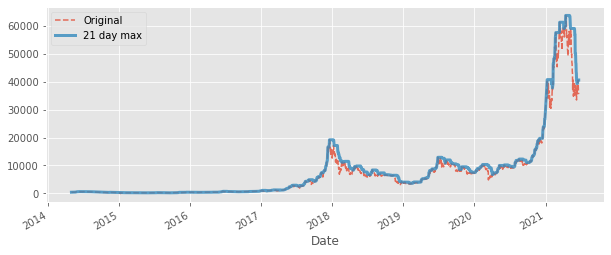

In [102]:
fig, ax = plt.subplots(figsize=(10, 4)) # size of the graph
btc_usd["Open"].plot(ax=ax, linestyle="--", alpha=0.8)
btc_usd.rolling("21d").max()["Open"].plot(ax=ax, alpha=0.8, linewidth=3) # it's calculating the local maxima values
ax.legend(["Original", "21 day max"]) # it tracks for us the global maxima over a 3 week horizon

We can also ask pandas to `apply` custom functions, similar to what we
saw when studying GroupBy.

In [103]:
def is_volatile(x):
    "Returns a 1 if the variance is greater than 1, otherwise returns 0"
    if x.var() > 1.0:
        return 1.0
    else:
        return 0.0

# in addition to applying a built in aggregator like mean
# we can actually ask pandas to add a groupby definition
# if variance is greater than 1, we assume that the data in x was VOLATILE

In [104]:
btc_small.rolling("2d").apply(is_volatile)

# variance of senquence of length 1 is always 0
# for each of the other windows we had volatile windows

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-05-03,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-05-04,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2014-05-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-05-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Exercise 5**

Imagine that you have access to the [TARDIS time machine](https://en.wikipedia.org/wiki/TARDIS)
from “Dr. Who”.

You are allowed to use the TARDIS only once, subject to the following
conditions:

- You may travel back to any day in the past.  
- On that day, you may purchase one bitcoin *at market open*.  
- You can then take the time machine 30 days into the future and sell your bitcoin *at market close*.  
- Then you return to the present, pocketing the profits.  

How would you pick the day?

Think carefully about what you would need to compute to make the
optimal choice. Try writing it out in the markdown cell below so you
have a clear description of the *want* operator that we will apply after
the exercise.

(Note: **Don’t** look too far below, because in the next non-empty cell
we have written out our answer.)

### Want
1. I would need a function
2. We need the rolling method here 
      To do this operation, pandas starts at each row (date) then looks
       *backwards* the specified number of periods (here 2 days) and then
       applies some aggregation function (`mean`) on all the data in that window.
3. Extract the bitcoin values at market open column from the result.
4. Find the date associated with the maximum value in that column. 


In [135]:
def daily_value(df):
    '''
    Solve exercise 5 to use in exercise 6
    '''

    data = df

    # shifting back 30 so the data a day t shows data from t+30 days in the future 
    day_shift = data.shift(-30)

    # difference in open price at day t and close price at day t+30
    oc_diff = day_shift['Close'] - data['Open']

    # adding to the data
    data['oc_diff'] = oc_diff

    # identifies the date with the largest 30 difference between and close prices
    marty = data['oc_diff'].idxmax()
    mcfly = data['oc_diff'].max() 

    return marty, mcfly

In [128]:
daily_value(btc_usd)

(Timestamp('2021-01-22 00:00:00'), 26675.050000000003)

In [130]:
btc_usd_diff = daily_value(btc_usd)
rolling_btc = btc_usd_diff.rolling('30d').max()
rolling_btc['Open'].idxmax

AttributeError: 'tuple' object has no attribute 'rolling'

In [131]:
btc_small.rolling('2d').apply(is_volatile)

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-05-03,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-05-04,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2014-05-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-05-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0


To make the optimal decision, we need to know the maximum
difference between the close price at the end of the window and the open
price at the start of the window.

**Exercise 6**

Do the following:

1. Write a pandas function that implements your strategy.  
1. Pass it to the `agg` method of `rolling_btc`.  
1. Extract the `"Open"` column from the result.  
1. Find the date associated with the maximum value in that column.  


How much money did you make?

In [ ]:
btc_small.rolling("2d").max()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-05-01,449.00,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-02,460.97,465.88,447.97,460.97,9556.037886,4.381969e+06,458.554960
2014-05-03,460.97,462.99,444.51,454.50,8269.891417,3.731061e+06,451.162018
2014-05-04,452.00,454.50,431.00,439.00,7431.626480,3.271086e+06,440.157544
2014-05-05,439.00,445.00,429.55,438.04,8188.082795,3.547855e+06,435.606483
2014-05-06,435.88,445.00,425.00,433.00,8188.082795,3.547855e+06,433.294968


In [133]:
def monthly_value(df):

    # resampling to find the max values each month
    month_max = df.resample('M').max()
    
    # finding the values for the first day of each month
    month_first = df.resample('M').first()

    # finding the difference between the max value of each month and the first day
    month_diff = month_max['Close'] - month_first['Open']

    # finding the month with the largest difference from start
    best_month = month_diff.idxmax()

    # changes the m=format of the best month so that every day from that month can be extracted from the original data set
    best_month1 = best_month.strftime("%Y-%b")

    # locates the specific data that had the highest closing price that month
    closing_day = df["Close"].loc[best_month1].idxmax()

    return best_month1, closing_day

In [134]:
monthly_value(btc_usd)

('2021-Feb', Timestamp('2021-02-21 00:00:00'))

## Changing Frequencies: `.resample`

In addition to computing rolling statistics, we can also change the
frequency of the data.

For example, instead of a monthly moving average, suppose that we wanted
to compute the average *within* each calendar month.

We will use the `resample` method to do this.

Below are some examples.

In [ ]:
# business quarter
btc_usd.resample("BQ").mean()

# resampling works for changing the frquency of the data
# insstead of computing a monthly moving average
# This helps us answer questions such as--> what was the aveerage price of bitcoin ag the beginning of every month
# we dont want to move in windows, but to resample the data
# BQ means business quarterly meanss = 4 quarters per year
# Look at dates--> end of the month

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-06-30,546.296557,560.478689,534.375574,549.274426,9692.850513,5.418439e+06,547.779109
2014-09-30,536.939130,544.464239,523.571087,533.646087,8921.203260,4.473120e+06,533.775317
2014-12-31,358.113261,367.361413,347.553261,357.277935,14487.630863,5.182557e+06,357.025437
2015-03-31,242.648111,250.373889,233.306667,241.823889,15871.493002,3.827028e+06,242.062305
2015-06-30,236.023956,239.404396,232.456593,236.209451,7568.650463,1.787362e+06,236.050265
2015-09-30,255.205435,259.369348,250.738478,254.964565,15057.220448,3.752239e+06,255.216907
2015-12-31,343.968043,354.843587,335.019783,346.029674,21987.668969,7.534306e+06,345.209689
2016-03-31,409.723956,415.345165,402.351319,409.552747,7276.401365,2.957477e+06,409.345434
2016-06-30,508.830549,519.757143,491.237582,511.820440,5981.137422,3.332013e+06,509.388134


Note that unlike with `rolling`, a single number is returned for
each column for each quarter.

The `resample` method will alter the frequency of the data and the
number of rows in the result will be different from the number of rows
in the input.

On the other hand, with `rolling`, the size and frequency of the result
are the same as the input.

We can sample at other frequencies and aggregate with multiple aggregations
function at once.

In [ ]:
# multiple functions at 2 start-of-quarter frequency
btc_usd.resample("2BQS").agg(["min", "max"])

# Semi-annually frquency
# beginning of the month

Open                High                 Low            \
                 min       max       min       max       min       max   
Date                                                                     
2014-04-01    374.17    668.90    386.03    683.26    365.20    651.70   
2014-10-01      0.00    426.64      0.00    453.92      0.00    390.48   
2015-04-01    209.76    310.55    222.88    317.99    198.12    292.19   
2015-10-01    235.87    464.53    239.06    502.00    235.00    453.50   
2016-04-01    414.66    767.37    416.99    778.85      1.50    740.11   
2016-10-03    607.19   1287.38    610.50   1350.00    604.99   1255.00   
2017-04-03   1076.59   4921.71   1145.00   4979.90   1076.19   4671.09   
2017-10-02   4219.74  19187.78   4343.00  19666.00   4137.96  18465.00   
2018-04-02   5845.20   9827.04   6165.49   9948.98   5774.72   9670.68   
2018-10-01   3180.84   6604.76   3230.00   6756.00   3122.28   6553.13   
2019-04-01   4092.02  12927.44   4150.00  13880.00   4052.56  12030.43   
2019-10-01   4841.67  10364.04   5353.04  10500.50   3850.00  10247.35   
2020-04-01   6428.74  12301.27   6710.21  12473.00   6137.71  11823.00   
2020-10-01  10543.17  61177.03  10605.79  61781.83  10380.00  58959.57   
2021-04-01  33413.19  63605.69  34085.61  64895.22  30066.00  61998.90   

               Close           Volume (BTC)                Volume (Currency)  \
                 min       max          min            max               min   
Date                                                                           
2014-04-01    374.20    670.14  1467.591402   29732.720362      9.159133e+05   
2014-10-01      0.00    426.63     0.000000  124188.885083      0.000000e+00   
2015-04-01    209.72    310.55  1946.293030   42308.005630      4.732609e+05   
2015-10-01    237.15    464.53  1253.006376  105959.259141      5.210775e+05   
2016-04-01    416.31    766.62   719.159825   33056.289644      4.709121e+05   
2016-10-03    607.19   1285.33   888.660021   36018.861120      5.460154e+05   
2017-04-03   1134.58   4921.70  1804.450797   60278.946542      2.128068e+06   
2017-10-02   4219.53  19187.78  4646.405621   70961.369658      2.032007e+07   
2018-04-02   5848.33   9823.28  1098.628060   33035.904045      7.093171e+06   
2018-10-01   3179.54   6604.75   839.297665   39775.389439      5.373482e+06   
2019-04-01   4136.32  12920.54  1572.155427   37487.802426      1.506857e+07   
2019-10-01   4841.67  10364.04  1119.109693   58513.389189      8.052271e+06   
2020-04-01   6619.00  12298.38  1358.285320   34465.186572      1.244918e+07   
2020-10-01  10553.66  61165.19     1.165644   40786.964254      3.152391e+04   
2021-04-01  33411.69  63564.48  1440.631820   32468.863970      8.294065e+07   

                         Weighted Price                
                     max            min           max  
Date                                                   
2014-04-01  1.561239e+07     376.976877    667.690345  
2014-10-01  2.357627e+07       0.000000    420.127183  
2015-04-01  9.091325e+06     214.884260    306.748292  
2015-10-01  4.719959e+07     237.116083    461.494358  
2016-04-01  2.225764e+07     415.569853    754.723539  
2016-10-03  3.883046e+07     607.560859   1275.581651  
2017-04-03  2.031684e+08    1127.151197   4808.168193  
2017-10-02  7.721430e+08    4233.863791  19110.244062  
2018-04-02  3.032200e+08    5936.398196   9827.536792  
2018-10-01  1.773528e+08    3171.722851   6593.879882  
2019-04-01  4.769830e+08    4121.008519  12723.686028  
2019-10-01  3.644311e+08    4876.575039  10345.096195  
2020-04-01  2.992075e+08    6357.380528  12166.197291  
2020-10-01  1.369434e+09   10515.174869  60429.059780  
2021-04-01  1.233364e+09   32661.425472  63314.685801

As with `groupby` and `rolling`, you can also provide custom
functions to `.resample(...).agg` and `.resample(...).apply`

**Exercise 7**

Now suppose you still have access to the TARDIS, but the conditions are
slightly different.

You may now:

- Travel back to the *first day* of any month in the past.  
- On that day, you may purchase one bitcoin *at market open*.  
- You can then travel to any day *in that month* and sell the bitcoin *at market close*.  
- Then return to the present, pocketing the profits.  

To which month would you travel? On which day of that month would you return
to sell the bitcoin?

Determine what you would need to compute to make the
optimal choice. Try writing it out in the markdown cell below so you
have a clear description of the *want* operator that we will apply after
the exercise.

(Note: **Don’t** look too many cells below, because we have written out
our answer.)

To make the optimal decision we need …

**Your answer here**

To make the optimal decision we need to, for each month,
compute the maximum value of the close price on any day minus the open
price on the first day of the month.

**Exercise 8**

Do the following:

1. Write a pandas function that implements your strategy.  
1. Pass it to the `agg` method of `resampled_btc`.  
1. Extract the `"Open"` column from the result.  
1. Find the date associated with the maximum value in that column.  


How much money did you make? Compare with your neighbor.

Was this strategy more profitable than the previous one? By how much?

In [ ]:
def monthly_value(df):
    # DELETE `pass` below and replace it with your code
    pass

resampled_btc = btc_usd.resample("MS")

# Do steps 2-4 here

## Optional: API keys

Recall above that we had the line of code:

```python
quandl.ApiConfig.api_key = "Dn6BtVoBhzuKTuyo6hbp"
```


This line told the `quandl` library that when obtaining making requests for data, it should use the *API key* `Dn6BtVoBhzuKTuyo6hbp`.

An API key is a sort of password that web services (like the Quandl API) require you to provide when you make requests.

Using this password, we were able to make a request to Quandl to obtain data directly from them.

The API key used here is one that we requested on behalf of this course.

If you plan to use Quandl more extensively, you should obtain your own personal API key from [their website](https://docs.quandl.com/docs#section-authentication) and re-run the `quandl.ApiConfig.api_key...` line of code with your new API key on the right-hand side.